# Coinbase Data Grabber

Use the [Coinbase](https://docs.cloud.coinbase.com/) api to collect historical trades, save results locally, and populate DataFrames() for analysis.

In [3]:
# First import the libraries that we need to use
import os
import glob
import fnmatch
import pandas as pd
import numpy as np
import time
import requests
import json
import warnings
import hvplot.pandas
import holoviews as hv
import panel as pn
from pathlib import Path
from datetime import datetime, timedelta
from bokeh.models.formatters import DatetimeTickFormatter, NumeralTickFormatter
from utils.coinbase import *
from dotenv import load_dotenv
# from utils.mc_forecast_tools import MCSimulation
# !nvidia-smi
load_dotenv()

True

## Created List of Coins

Fetch the coinbase products listings, save locally and create DataFrames()

In [4]:
# Get list of currencies and the exchange details from the coinbase api
currencies_df = get_currencies()
products_online_df = get_products()

# display(currencies_df.head(3))
# display(currencies_df.tail(3))
# display(products_online_df.head(3))
# display(products_online_df.tail(3))

## Filter by `base_currency` to get all crypto currencies by fiat `USD` and import into a DataFrame
btc_usd_products_df = products_online_df.loc[(products_online_df['base_currency'] == 'BTC')&(products_online_df['quote_currency'] == 'USD')].copy().drop(columns=["quote_currency"])
eth_usd_products_df = products_online_df.loc[(products_online_df['base_currency'] == 'ETH')&(products_online_df['quote_currency'] == 'USD')].copy().drop(columns=["quote_currency"])
btc_products_df = products_online_df.loc[(products_online_df['quote_currency'] == 'BTC')].copy().drop(columns=["quote_currency"])
eth_products_df = products_online_df.loc[(products_online_df['quote_currency'] == 'ETH')].copy().drop(columns=["quote_currency"])

# # To display the lengths of the above DataFrames, uncomment these lines: 
# print(f"BTC-USD-based data has {len(btc_usd_products_df)} records")
# print(f"ETH-USD-based data has {len(eth_usd_products_df)} records")
# print(f"BTC-based data has {len(btc_products_df)} records")
# print(f"ETH-based data has {len(eth_products_df)} records")

# THIS IS THE FULL LIST OF AVAILABLE COINS ON THIS EXCHANGE.
# (We will hand-pick the coins since there are only four PoS coins on this exchange)
all_coins = ['SUSHI-ETH', 'MANA-ETH', 'ADA-ETH', 'SOL-ETH', 'BAT-ETH', 'LINK-ETH', 'ENJ-BTC', 'FIL-BTC', 'WBTC-BTC', 'ETC-BTC', 'BAND-BTC',
             'LRC-BTC', 'ETH-BTC', 'GRT-BTC', 'MIR-BTC', 'LINK-BTC', 'ZEN-BTC', 'BAL-BTC', 'BNT-BTC', 'SUSHI-BTC', 'TRB-BTC', 'SNX-BTC', 
             'NKN-BTC', 'ALGO-BTC', 'STORJ-BTC', 'COMP-BTC', 'ZEC-BTC', 'AAVE-BTC', 'ICP-BTC', 'EOS-BTC', 'ANKR-BTC', 'AVAX-BTC', 'BCH-BTC',
             'DASH-BTC', 'REQ-BTC', 'BAT-BTC', 'KNC-BTC', 'MANA-BTC', 'RLC-BTC', 'ADA-BTC', 'XLM-BTC', 'UNI-BTC', 'UMA-BTC', 'CGLD-BTC', 'SKL-BTC', 
             'OMG-BTC', 'OGN-BTC', 'XTZ-BTC', 'YFI-BTC', 'TRU-BTC', 'CTSI-BTC', 'LTC-BTC', 'DOGE-BTC', 'REN-BTC', '1INCH-BTC', 'XYO-BTC', 'NMR-BTC', 
             'ORN-BTC', 'FORTH-BTC', 'WCFG-BTC', 'RAD-BTC', 'MATIC-BTC', 'DOT-BTC', 'AXS-BTC', 'SOL-BTC', 'ATOM-BTC', 'ZRX-BTC', 'MKR-BTC', 'REP-BTC', 
             'CRV-BTC', 'NU-BTC', 'BTRST-BTC']

# Pandas concat() inner join into a list()
pow_coins = pd.concat([btc_usd_products_df['id'],eth_usd_products_df['id']], join="inner").tolist()
pos_coins = ["ADA-BTC","SOL-BTC","ALGO-BTC","XTZ-BTC"]

print(f"PoW: {pow_coins}")
print(f"PoS: {pos_coins}")

Created CSV file: data/coinbase_currencies.csv
Created CSV file: data/coinbase_products.csv
PoW: ['BTC-USD', 'ETH-USD']
PoS: ['ADA-BTC', 'SOL-BTC', 'ALGO-BTC', 'XTZ-BTC']


## Fetch and Compile Historical Data

Call functions `fetch_return_history()` and `merge_candle_data()` on our PoW and PoS lists to fetch results, save them locally, and populate DataFrames() for analysis.

Data must be retrieved in chunks of 300. The sequence is (+/-300 days) [0,300,600,900,1200,etc...]

In [3]:
# # FETCH RETURN HISTORY
# # Set this range() top value to the max number of days to return.  We do 1200 on these coins but there is not any data before that time.

# seq = list(range(0, 1200, 300))
# for crypt in pow_coins:
#     fetch_return_history(crypt,"2022-05-18",seq)

# for crypt in pow_coins:
#     merge_candle_data(crypt)

# for crypt in pos_coins:
#     fetch_return_history(crypt,"2022-05-18",seq)

# for crypt in pos_coins:
#     merge_candle_data(crypt)


## Create the DataFrames from fetched data and transform

In [29]:
## Exampine teh download data:
extension = 'csv'
files = glob.glob('data/product/candles/merged/*.{}'.format(extension))
file_dict = {}
for file in files:
    key = file
    df = pd.read_csv(file)
    file_dict[key] = df

# `Rename our dataframes from the aut-generated ones:
# NOTE: I still need to go back and delete `Unnamed: 0` and `unix` before they're imported
ada_df = file_dict["data/product/candles/merged/coinbase_ADA-BTC_candles_ALL.csv"].drop(columns=["Unnamed: 0","unix","date"])#.set_index("time")  # next cell wont run if index is set
sol_df = file_dict["data/product/candles/merged/coinbase_SOL-BTC_candles_ALL.csv"].drop(columns=["Unnamed: 0","unix","date"])#.set_index("time")
algo_df = file_dict["data/product/candles/merged/coinbase_ALGO-BTC_candles_ALL.csv"].drop(columns=["Unnamed: 0","unix","date"])#.set_index("time")
xtz_df = file_dict["data/product/candles/merged/coinbase_XTZ-BTC_candles_ALL.csv"].drop(columns=["Unnamed: 0","unix","date"])#.set_index("time")
btc_df = file_dict["data/product/candles/merged/coinbase_BTC-USD_candles_ALL.csv"].drop(columns=["Unnamed: 0","unix","date"])#.set_index("time")
eth_df = file_dict["data/product/candles/merged/coinbase_ETH-USD_candles_ALL.csv"].drop(columns=["Unnamed: 0","unix","date"])#.set_index("time")


print(f"ADA records:{len(ada_df)}")
print(f"SOL records:{len(sol_df)}")
print(f"ALGO records:{len(algo_df)}")
print(f"XTZ records:{len(xtz_df)}")
print(f"BTC records:{len(btc_df)}")
print(f"ETH records:{len(eth_df)}")

ADA records:851
SOL records:669
ALGO records:1051
XTZ records:2027
BTC records:2392
ETH records:2392


In [30]:
# Group the listings into `portfolios`
BTC = btc_df
ETH = eth_df
ADA = ada_df
SOL = sol_df
ALGO = algo_df
XTZ = xtz_df

# Concatenate and group by tickers
pow_coins_df = pd.concat([BTC, ETH], axis=1, keys=["BTC", "ETH"])
pos_coins_df = pd.concat([ADA, SOL, ALGO, XTZ], axis=1, keys=["ADA", "SOL", "ALGO", "XTZ"])

## Show the top 5 rows from both DataFrames
print(f"PoW records:{len(pow_coins_df)}")
display(pow_coins_df.head(3))
print(f"\nSoW records:{len(pos_coins_df)}")
display(pos_coins_df.tail(3))

PoW records:2392


BTC                                                          \
      close      high       low      open        time      vol_fiat   
0  28672.94  30675.92  28605.00  30412.10  2022-05-18  8.128327e+08   
1  30412.12  30750.00  29415.01  29839.89  2022-05-17  6.031729e+08   
2  29839.89  31293.31  29055.00  31290.02  2022-05-16  6.757597e+08   

                     ETH                                                       \
         volume    close     high      low     open        time      vol_fiat   
0  28348.426436  1911.98  2108.80  1905.24  2088.95  2022-05-18  3.455107e+08   
1  19833.306767  2088.96  2120.00  2005.00  2020.57  2022-05-17  3.200965e+08   
2  22646.185074  2020.58  2142.82  1976.22  2142.74  2022-05-16  3.810823e+08   

                  
          volume  
0  180708.340046  
1  153232.486718  
2  188600.428781


SoW records:2027


ADA                                      SOL           ... ALGO  \
     close high low open time vol_fiat volume close high low  ... time   
2024   NaN  NaN NaN  NaN  NaN      NaN    NaN   NaN  NaN NaN  ...  NaN   
2025   NaN  NaN NaN  NaN  NaN      NaN    NaN   NaN  NaN NaN  ...  NaN   
2026   NaN  NaN NaN  NaN  NaN      NaN    NaN   NaN  NaN NaN  ...  NaN   

                           XTZ                                            \
     vol_fiat volume     close      high       low      open        time   
2024      NaN    NaN  0.000131  0.000174  0.000111  0.000112  2019-08-08   
2025      NaN    NaN  0.000113  0.000139  0.000112  0.000130  2019-08-07   
2026      NaN    NaN  0.000129  0.000168  0.000118  0.000118  2019-08-06   

                              
        vol_fiat      volume  
2024  231.696159  1768807.99  
2025   34.502576   306498.85  
2026   79.962080   620390.10  

[3 rows x 28 columns]

## Run the MC Simulation

This step generates a `daily_returns` column and displays the simulation results in an overlay plot.

<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 364 Trading Days.'}>

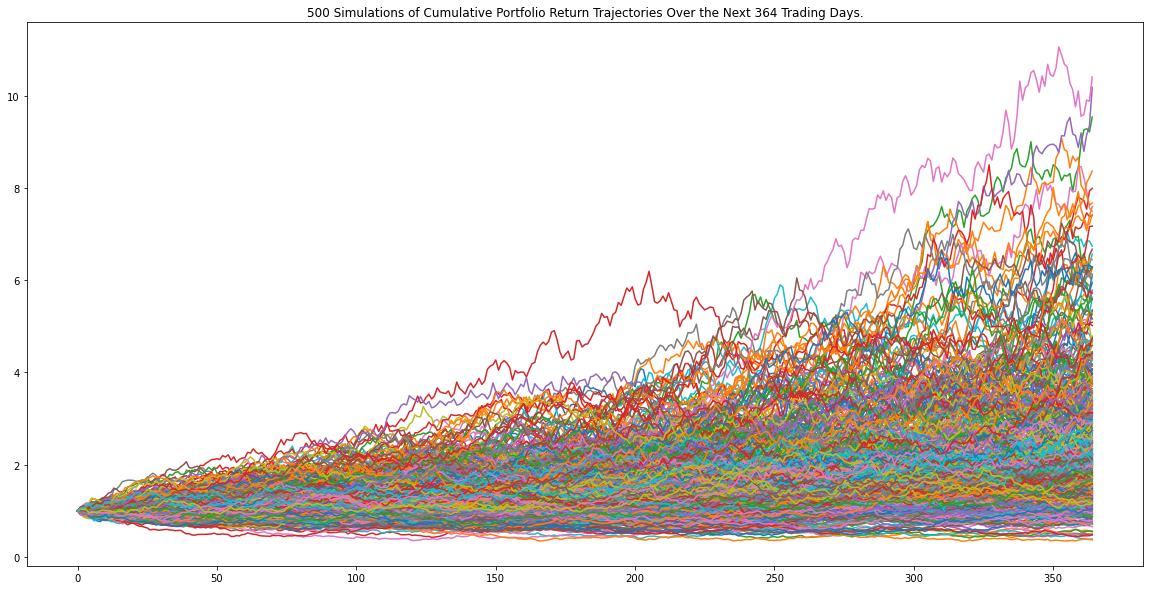

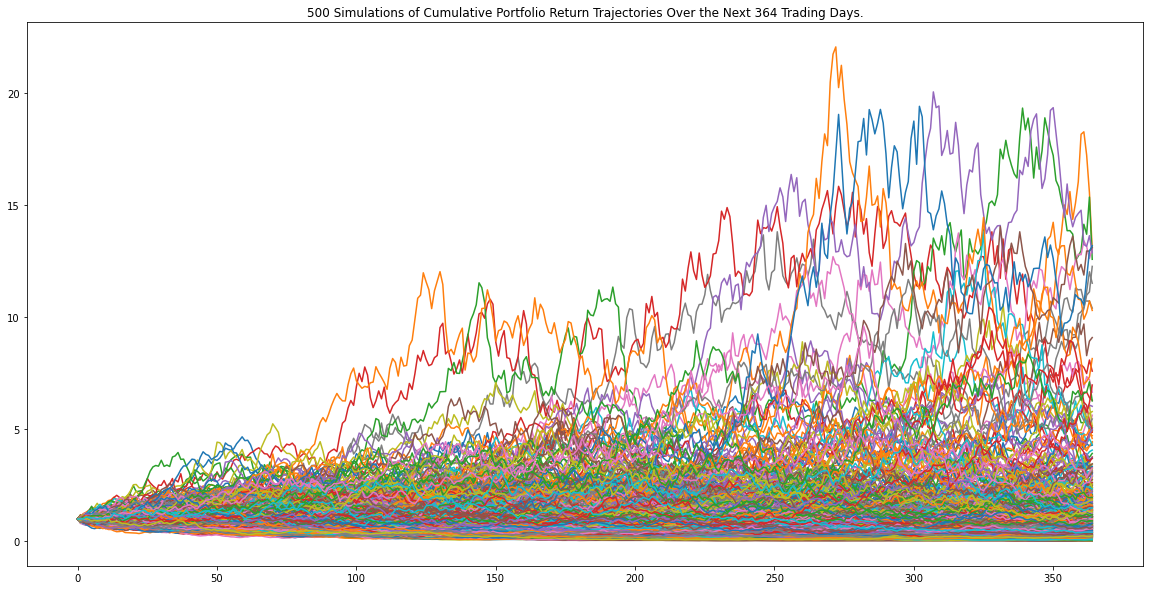

In [7]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns
import warnings

MC_PoS_equal_weights = MCSimulation(
    portfolio_data = pos_coins_df[:334], # !!!! had to truncate... because of the nans :/
    weights = [.25,.25,.25,.25],
    num_simulation = 500,
    num_trading_days = 364
)

MC_PoW_equal_weights = MCSimulation(
    portfolio_data = pow_coins_df,
    weights = [.5,.5],
    num_simulation = 500,
    num_trading_days = 364
)

# Turn off output warnings
warnings.filterwarnings('ignore')

# Run the MC functions to generate the data
MC_PoS_equal_weights.calc_cumulative_return()
MC_PoW_equal_weights.calc_cumulative_return()

MC_PoS_equal_weights.plot_simulation()
MC_PoW_equal_weights.plot_simulation()

## Calculate Daily Returns
Create new dataframes to show plot of cumulative returns, volatility, etc.

In [31]:
# Concatenate and group by tickers

# btc_df = file_dict["data/product/candles/merged/coinbase_BTC-USD_candles_ALL.csv"].drop(columns=["Unnamed: 0","unix","date","high","low","open","vol_fiat","volume"]).set_index("time")
# eth_df = file_dict["data/product/candles/merged/coinbase_ETH-USD_candles_ALL.csv"].drop(columns=["Unnamed: 0","unix","date","high","low","open","vol_fiat","volume"]).set_index("time")
# ada_df = file_dict["data/product/candles/merged/coinbase_ADA-BTC_candles_ALL.csv"].drop(columns=["Unnamed: 0","unix","date","high","low","open","vol_fiat","volume"]).set_index("time")
# sol_df = file_dict["data/product/candles/merged/coinbase_SOL-BTC_candles_ALL.csv"].drop(columns=["Unnamed: 0","unix","date","high","low","open","vol_fiat","volume"]).set_index("time")
# algo_df = file_dict["data/product/candles/merged/coinbase_ALGO-BTC_candles_ALL.csv"].drop(columns=["Unnamed: 0","unix","date","high","low","open","vol_fiat","volume"]).set_index("time")
# xtz_df = file_dict["data/product/candles/merged/coinbase_XTZ-BTC_candles_ALL.csv"].drop(columns=["Unnamed: 0","unix","date","high","low","open","vol_fiat","volume"]).set_index("time")

# PoW
btc_df["pct_change"] = btc_df["close"].pct_change().dropna()
btc_df["pct_change"] = btc_df["pct_change"].fillna(0)
btc_df["cum_prod"] = (1 + btc_df["pct_change"]).cumprod().fillna(0)
eth_df["pct_change"] = eth_df["close"].pct_change().dropna().fillna(0)
eth_df["pct_change"] = eth_df["pct_change"].fillna(0)
eth_df["cum_prod"] = (1 + eth_df["pct_change"]).cumprod().fillna(0)

# PoS
ada_df["pct_change"] = ada_df["close"].pct_change().dropna().fillna(0)
ada_df["pct_change"] = ada_df["pct_change"].fillna(0)
ada_df["cum_prod"] = (1 + ada_df["pct_change"]).cumprod().fillna(0)
sol_df["pct_change"] = sol_df["close"].pct_change().dropna().fillna(0)
sol_df["pct_change"] = sol_df["pct_change"].fillna(0)
sol_df["cum_prod"] = (1 + sol_df["pct_change"]).cumprod().fillna(0)
algo_df["pct_change"] = algo_df["close"].pct_change().dropna().fillna(0)
algo_df["pct_change"] = algo_df["pct_change"].fillna(0)
algo_df["cum_prod"] = (1 + algo_df["pct_change"]).cumprod().fillna(0)
xtz_df["pct_change"] = xtz_df["close"].pct_change().dropna().fillna(0)
xtz_df["pct_change"] = xtz_df["pct_change"].fillna(0)
xtz_df["cum_prod"] = (1 + xtz_df["pct_change"]).cumprod().fillna(0)

display(xtz_df.head(3))
display(xtz_df.tail(3))

,close,high,low,open,time,vol_fiat,volume,pct_change,cum_prod
0,0.000058,0.000062,0.000058,0.000061,2022-05-18,15.376133,262974.74,0.000000,1.000000
1,0.000061,0.000061,0.000059,0.000060,2022-05-17,11.042639,180671.45,0.045322,1.045322
2,0.000060,0.000061,0.000058,0.000061,2022-05-16,14.263558,239723.67,-0.026505,1.017616


,close,high,low,open,time,vol_fiat,volume,pct_change,cum_prod
2024,0.000131,0.000174,0.000111,0.000112,2019-08-08,231.696159,1768807.99,0.090130,2.240294
2025,0.000113,0.000139,0.000112,0.000130,2019-08-07,34.502576,306498.85,-0.140621,1.925261
2026,0.000129,0.000168,0.000118,0.000118,2019-08-06,79.962080,620390.10,0.144976,2.204378


In [56]:
# Plot the cumulative returns data

# Set the index for proper time management
date_today = datetime.now()
days = pd.date_range(date_today, date_today + timedelta(7), freq='D')

# Formatters for the x axis
formatter_dt = DatetimeTickFormatter(days='%m/%d\n(%Y)', months='%m/%Y', years='%Y')
formatter_usd = NumeralTickFormatter(format="$0,0")
formatter_pct = NumeralTickFormatter(format="0.0%")
formatter_eth = NumeralTickFormatter(format="Ξ0.0000000")
formatter_btc = NumeralTickFormatter(format="₿0.0000000")

def _transform_data(raw_data: pd.DataFrame):
    data = raw_data.copy(deep=False)
    data = data.reset_index()
    data['time'] = pd.to_datetime(data['time'])
    # data = data.drop(columns=['date'])
    # t_delta = timedelta(hours=0.6)
    # data['time_start'] = data['time'] - 6*t_delta # rectangles start
    # data['time_end'] = data['time'] + 6*t_delta    # rectangles end
    # data['positive'] = ((data['close'] - data['open'])>0).astype(int)
    return data


def make_line_plot(data, col):
    plot = data.hvplot(x="time", y="cum_prod", kind="line", responsive=True, height=300).opts(
        xformatter=formatter_dt,
        yformatter=formatter_pct,
        line_color=col,
        line_width=1,
        ylabel='',
        xlabel='',
        title="Cumulative Returns"
    )
    return plot

def make_area_plot(data, col):
    plot = data.hvplot.area(x="time", y="low", y2="high", width=1200, height=500, stacked=False, legend='bottom_right').opts(
        xformatter=formatter_dt,
        yformatter=formatter_pct,
        line_color=col,
        line_width=0.8,
        fill_color=col,
        fill_alpha=0.2,
        ylabel='',
        xlabel='',
        title="Low - High per coin"
    )
    return plot

    
data1 = _transform_data(raw_data=btc_df)
data2 = _transform_data(raw_data=eth_df)
data3 = _transform_data(raw_data=ada_df)
data4 = _transform_data(raw_data=sol_df)
data5 = _transform_data(raw_data=algo_df)
data6 = _transform_data(raw_data=xtz_df)

make_area_plot(data1, "red") * make_area_plot(data2, "orange") * make_area_plot(data3, "yellow") * make_area_plot(data4, "green") * make_area_plot(data5, "blue") * make_area_plot(data6, "purple")


:Overlay
   .Area.I   :Area   [time]   (low,high)
   .Area.II  :Area   [time]   (low,high)
   .Area.III :Area   [time]   (low,high)
   .Area.IV  :Area   [time]   (low,high)
   .Area.V   :Area   [time]   (low,high)
   .Area.VI  :Area   [time]   (low,high)

In [65]:
## Create candle plot with overlay and sychronized sencondary plot
# Formatters for the x axis
formatter_dt = DatetimeTickFormatter(days='%m/%d\n(%Y)', months='%m/%Y', years='%Y')
formatter_usd = NumeralTickFormatter(format="$0,0")
formatter_usd_sm = NumeralTickFormatter(format="$0.0")

def _transform_data(raw_data: pd.DataFrame):
    data = raw_data.copy(deep=True)
    data['time'] = pd.to_datetime(data['time'])
    # data = data.drop(columns=['date'])
    t_delta = timedelta(hours=0.6)
    data['time_start'] = data['time'] - 6*t_delta # rectangles start
    data['time_end'] = data['time'] + 6*t_delta    # rectangles end
    data['positive'] = ((data['close'] - data['open'])>0).astype(int)
    return data

def make_candle_stick_a(data):
    _delta = np.median(np.diff(data.time))
    candlestick_a = hv.Segments(data, kdims=['time', 'low', 'time', 'high']) * hv.Rectangles(data, kdims=['time_start','open', 'time_end', 'close'], vdims=['positive'])
    candlestick_a = candlestick_a.redim.label(Low='Values')
    return candlestick_a.opts(hv.opts.Rectangles(color='positive', cmap=['red', 'green'], alpha=0.9), hv.opts.Segments(color='gray',  alpha=0.9, line_width=0.8))

def make_daily_open_plot_a(data):
    plot = data.hvplot(x="time", y="open", kind="line", responsive=True, height=600).opts(
        xformatter=formatter_dt,
        yformatter=formatter_usd_sm,
        line_color='lightgreen',
        alpha=0.7,
        line_width=0.75,
        ylabel='',
        xlabel=''
    )
    return plot

def make_daily_close_plot_a(data):
    plot = data.hvplot(x="time", y="close", kind="line", responsive=True, height=600).opts(
        xformatter=formatter_dt,
        yformatter=formatter_usd_sm,
        line_color='lightgreen',
        alpha=0.7,
        line_width=0.75,
        ylabel='',
        xlabel=''
    )
    return plot

def make_volume_plot_a(data):
    plot = data.hvplot(x="time", y="volume", kind="area", responsive=True, height=300).opts(
        xformatter=formatter_dt,
        yformatter=formatter_usd,
        fill_color='lightgray',
        alpha=0.5,
        line_width=0.75,
        ylabel='',
        xlabel=''
    )
    return plot

def make_candle_stick_b(data2):
    _delta = np.median(np.diff(data2.time))
    candlestick_b = hv.Segments(data2, kdims=['time', 'low', 'time', 'high']) * hv.Rectangles(data2, kdims=['time_start','open', 'time_end', 'close'], vdims=['positive'])
    candlestick_b = candlestick_b.redim.label(Low='Values')
    return candlestick_b.opts(hv.opts.Rectangles(color='positive', cmap=['red', 'green'], alpha=0.9), hv.opts.Segments(color='gray',  alpha=0.9, line_width=0.8))

def make_daily_open_plot_b(data2):
    plot = data2.hvplot(x="time", y="open", kind="line", responsive=True, height=600).opts(
        xformatter=formatter_dt,
        yformatter=formatter_usd_sm,
        line_color='lightblue',
        alpha=0.9,
        line_width=0.75,
        ylabel='',
        xlabel=''
    )
    return plot

def make_daily_close_plot_b(data2):
    plot = data2.hvplot(x="time", y="close", kind="line", responsive=True, height=600).opts(
        xformatter=formatter_dt,
        yformatter=formatter_usd_sm,
        line_color='lightblue',
        alpha=0.9,
        line_width=0.75,
        ylabel='',
        xlabel=''
        # hover_cols=['symbol', 'year']
    )
    return plot

def make_volume_plot_b(data2):
    plot = data2.hvplot(x="time", y="volume", kind="area", responsive=True, height=300).opts(
        xformatter=formatter_dt,
        yformatter=formatter_usd,
        fill_color='lightblue',
        alpha=0.5,
        line_width=0.75,
        ylabel='',
        xlabel=''
    )
    return plot


data = _transform_data(raw_data=sol_df)
data2 = _transform_data(raw_data=algo_df)

candle_stick_plot_a = make_candle_stick_a(data)
daily_open_plot_a = make_daily_open_plot_a(data)
daily_close_plot_a = make_daily_close_plot_a(data)
volume_plot_a = make_volume_plot_a(data)

candle_stick_plot_b = make_candle_stick_b(data2)
daily_open_plot_b = make_daily_open_plot_b(data2)
daily_close_plot_b = make_daily_close_plot_b(data2)
volume_plot_b = make_volume_plot_b(data2)


pn.pane.HoloViews((((candle_stick_plot_a*daily_open_plot_a*daily_close_plot_a)*(candle_stick_plot_b*daily_open_plot_b*daily_close_plot_b))+(volume_plot_a*volume_plot_b)).cols(1), sizing_mode="stretch_both").servable()


HoloViews(Layout, sizing_mode='stretch_both')

In [89]:
## Create candle plot with overlay and sychronized sencondary plot
# Formatters for the x axis
formatter_dt = DatetimeTickFormatter(days='%m/%d\n(%Y)', months='%m/%Y', years='%Y')
formatter_usd = NumeralTickFormatter(format="$0,0")
formatter_usd_sm = NumeralTickFormatter(format="$0.0")


# ['SOL-ETH', 'MANA-ETH', 'LINK-ETH', 'SUSHI-ETH', 'ADA-ETH', 'BAT-ETH', 'NMR-BTC', 'CGLD-BTC', 'NU-BTC', 'BTRST-BTC']

def _transform_data(raw_data: pd.DataFrame):
    data = raw_data.copy(deep=True)
    data['time'] = pd.to_datetime(data['time'])
    # data = data.drop(columns=['date'])
    t_delta = timedelta(hours=0.6)
    data['time_start'] = data['time'] - 6*t_delta # rectangles start
    data['time_end'] = data['time'] + 6*t_delta    # rectangles end
    data['positive'] = ((data['close'] - data['open'])>0).astype(int)
    return data

def make_candle_stick(data):
    _delta = np.median(np.diff(data.time))
    candlestick = hv.Segments(data, kdims=['time', 'low', 'time', 'high']) * hv.Rectangles(data, kdims=['time_start','open', 'time_end', 'close'], vdims=['positive'])
    candlestick = candlestick.redim.label(Low='Values')
    return candlestick.opts(hv.opts.Rectangles(color='positive', cmap=['red', 'green'], alpha=0.9), hv.opts.Segments(color='gray',  alpha=0.9, line_width=0.8))

def make_daily_open_plot(data):
    plot = data.hvplot(x="time", y="open", kind="line", responsive=True, height=500).opts(
        xformatter=formatter_dt,
        yformatter=formatter_usd_sm,
        line_color='lightgreen',
        alpha=0.7,
        line_width=0.75,
        ylabel='',
        xlabel=''
    )
    return plot

def make_daily_close_plot(data):
    plot = data.hvplot(x="time", y="close", kind="line", responsive=True, height=500).opts(
        xformatter=formatter_dt,
        yformatter=formatter_usd_sm,
        line_color='lightgreen',
        alpha=0.7,
        line_width=0.75,
        ylabel='',
        xlabel=''
    )
    return plot

def make_volume_plot(data):
    plot = data.hvplot(x="time", y="vol_fiat", kind="area", height=50).opts(
        # height=100,
        xformatter=formatter_dt,
        yformatter=formatter_usd,
        fill_color='lightgray',
        alpha=0.5,
        line_width=0.75,
        ylabel='',
        xlabel=''
    )
    return plot


data = _transform_data(raw_data=btc_df)

candle_stick_plot = make_candle_stick(data)
daily_open_plot = make_daily_open_plot(data)
daily_close_plot = make_daily_close_plot(data)
volume_plot = make_volume_plot(data)

# pn.pane.HoloViews(((candle_stick_plot*daily_open_plot*daily_close_plot)+(volume_plot_a*volume_plot_b)).cols(1), sizing_mode="stretch_both").servable()
pn.pane.HoloViews(((candle_stick_plot*daily_open_plot*daily_close_plot)+(volume_plot_a*volume_plot_b)).cols(1), sizing_mode="stretch_width").servable()

HoloViews(Layout, sizing_mode='stretch_width')